In [ ]:
import pandas as pd
import json
import tqdm

from datasets import load_dataset

from langchain.document_loaders import JSONLoader

# Load documents

In [45]:
# DONT USE AUG DATASET FOR THE MOMENT
#dataset = pd.read_json("../data/cs_CLpapers_aug.jsonl", lines=True)
#dataset.dropna(subset=["content"], inplace=True)

# CURRENTLY ONLY USING ABSTRACT SUMMARY TO INSERT AS EMBEDDING VECTORS IN DB
#dataset = pd.read_json("../data/cs_CLpapers.jsonl", lines=True)
#dataset.dropna(subset=["summary"], inplace=True)

In [48]:
# Define the metadata extraction function.
def metadata_func(record: dict, metadata: dict) -> dict:

    metadata["title"] = record.get("title")
    metadata["pdf_url"] = record.get("pdf_url")

    return metadata

In [148]:
cat = "cs_CL"

In [72]:
# *** ONLY LOAD ABSTRACTS ***
loader = JSONLoader(
    file_path=f"../data/{cat}papers.jsonl",
    jq_schema='.',
    content_key="summary",
    metadata_func=metadata_func,
    json_lines=True)

docs = loader.load()

# Use THIS

In [132]:
# LOAD PAPER CONTENT
loader = JSONLoader(
    file_path=f"../data/{cat}papers_aug_clean.jsonl",
    jq_schema='.',
    content_key="content",
    metadata_func=metadata_func,
    json_lines=True)

docs = loader.load()

# Document preprocessing

- Remove \n ???
- Truncate docs using max token count
- Tile docs using RecursiveTextSplitter with overlap

![Tokenizers](../media/tokenizers.png)

- call tiktoken.encoding_for_model("text-davinci-003")
- https://github.com/openai/tiktoken/blob/main/tiktoken/model.py

In [134]:
# *** USE APPROPRIATE TOKENIZER IF NOT USEN OPENAI MODELS ***
tokenizer = tiktoken.get_encoding("cl100k_base") # use this tokenizer for gpt-3.5-turbo

In [135]:
def tiktoken_len(text):
    
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    
    return len(tokens)

In [136]:
token_counts = [tiktoken_len(x.page_content) for x in docs]

print("min token count: ", min(token_counts))
print("max token count: ", max(token_counts))
print("avg token count: ", int(sum(token_counts)/len(token_counts)))

min token count:  1261
max token count:  126647
avg token count:  11197


/Users/kieranschubert/Desktop/RAG-ML/venv_rag/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kieranschubert/Desktop/RAG-ML/venv_rag/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


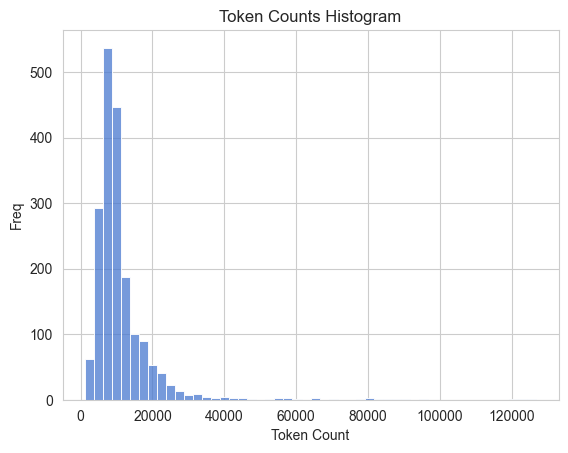

In [137]:
sns.set_style("whitegrid")
sns.set_palette("muted")

fig, ax = plt.subplots()

sns.histplot(token_counts, kde=False, bins=50, ax=ax)

ax.set_title("Token Counts Histogram")
ax.set_ylabel("Freq")
ax.set_xlabel("Token Count")

plt.show()

# RecursiveTextSplitter

- gpt-3.5-turbo has a max context window of 4096 tokens: this includes the prompt (instructions + context + query) and generated answer

In [138]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""])

In [139]:
documents = []

for doc in tqdm.tqdm(docs):

    m.update(doc.metadata["pdf_url"].encode("utf-8"))
    uid = m.hexdigest()[:10]
    chunks = text_splitter.split_text(doc.page_content)
    
    for i, chunk in enumerate(chunks):
        documents.append({
            "id": f"{uid}-{i}",
            "text": chunk,
            "title": doc.metadata["title"],
            "source": doc.metadata["pdf_url"]
        })

len(documents)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1897/1897 [00:34<00:00, 55.00it/s]


59384

In [151]:
# save documents
with open(f"../data/{cat.replace('.', '_')}_train.jsonl", "w") as outfile:
    for doc in documents:
        outfile.write(json.dumps(doc) + '\n')

In [152]:
# read documents
documents = []

with open(f"../data/{cat.replace('.', '_')}_train.jsonl", "r") as infile:
    for line in infile:
        documents.append(json.loads(line))

len(documents)

59384

In [ ]:
# Load dataset from Huggingface
documents = load_dataset("kieranschubert/arxiv_cs_CL_train", split="train")